<a href="https://colab.research.google.com/github/Polutan/ml-model/blob/main/Air_Quality_Forecast_in_Yogyakarta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Tensorflow**

In [1]:
import tensorflow as tf

## **Importing Libraries and Preparing Plot Series**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("ISPU")
  plt.grid(True)  

In [ ]:
# import csv
# time_step = []
# ispu = []

# with open('drive/MyDrive/Yogyakarta 2021.csv') as csvfile:
#   reader = csv.reader(csvfile, delimiter=',')
#   next(reader)
#   for row in reader:
#     ispu.append(float(row[9]))
#     time_step.append(int(row[0]))

# series = np.array(ispu)
# time = np.array(time_step)
# plt.figure(figsize=(10, 6))
# plot_series(time, series)

## **Uploading DataSet**

Source Dataset: https://www.kaggle.com/datasets/adhang/air-quality-in-yogyakarta-indonesia-2021

This dataset contains air pollution measurements, such as Particulate Matter (PM10, PM2.5), Sulfur Dioxide (SO2), Carbon Monoxide (CO), Ozone (O3), and Natrium Dioxide (NO2). The measurement has been converted to pollutant standards index (PSI) or Indeks Standar Pencemaran Udara (ISPU)

The max Column here stand for the maximum ISPU score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('drive/MyDrive/Yogyakarta 2021.csv')

df.head()

,No,Date,Time,PM10,PM2.5,SO2,CO,O3,NO2,Max,Critical Component,Category
0,1,1/1/2021,0:00:00,13.0,40.0,0.0,25.0,0.0,0.0,40,PM2.5,Good
1,2,1/1/2021,1:00:00,12.0,38.0,0.0,24.0,0.0,0.0,38,PM2.5,Good
2,3,1/1/2021,2:00:00,11.0,35.0,0.0,23.0,0.0,0.0,35,PM2.5,Good
3,4,1/1/2021,3:00:00,10.0,32.0,0.0,22.0,0.0,0.0,32,PM2.5,Good
4,5,1/1/2021,4:00:00,9.0,29.0,0.0,21.0,0.0,0.0,29,PM2.5,Good


These are the features that will be use in the training and validating the model. "No" is the time step of the time series data and "Max" is the maximum value of ISPU in that hour.



In [5]:
feature = ['No', 'Max']
df[feature].head()

,No,Max
0,1,40
1,2,38
2,3,35
3,4,32
4,5,29


## **Preprocessing Data**

There is a missing value that filled as 0. We are going to replace that value with mean value of the "Max" feature.

In [6]:
print(df.loc[4430])

No                        4431
Date                  7/4/2021
Time                  14:00:00
PM10                       NaN
PM2.5                      NaN
SO2                        NaN
CO                         NaN
O3                         NaN
NO2                        NaN
Max                          0
Critical Component         NaN
Category                  Good
Name: 4430, dtype: object


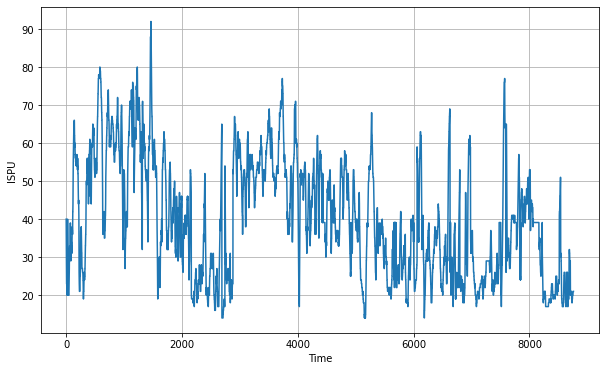

In [7]:
mean = df['Max'].mean()
df['Max'] = df['Max'].replace(0, mean)

time = np.array(df['No'].values.tolist())
series = np.array(df['Max'].values.tolist())

plt.figure(figsize=(10, 6))
plot_series(time, series)


## **Preparing Dataset for Training and Testing**

In [8]:
split_time = 720
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 24
batch_size = 32
shuffle_buffer_size = 1000

## **Windowing Dataset**

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## **Training The Dataset**

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])


In [11]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9))


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                500       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(dataset,epochs=100,verbose=0)


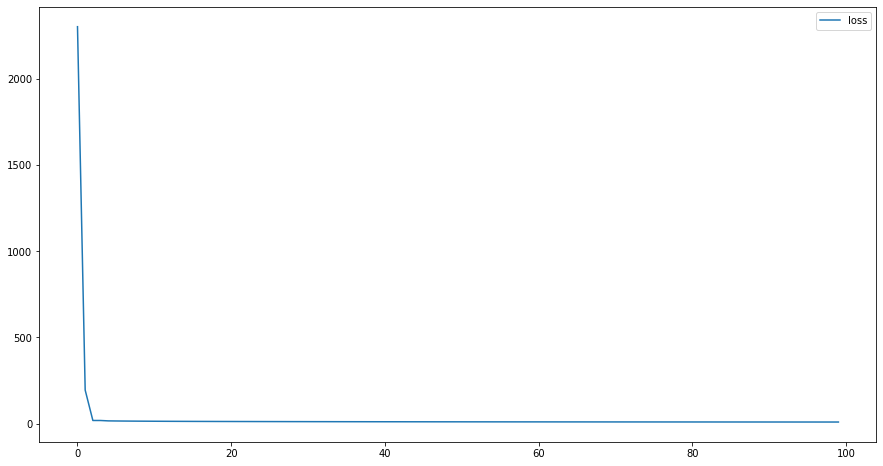

In [14]:
pd.DataFrame(history.history).plot(figsize=(15,8))

## **Forecasting**

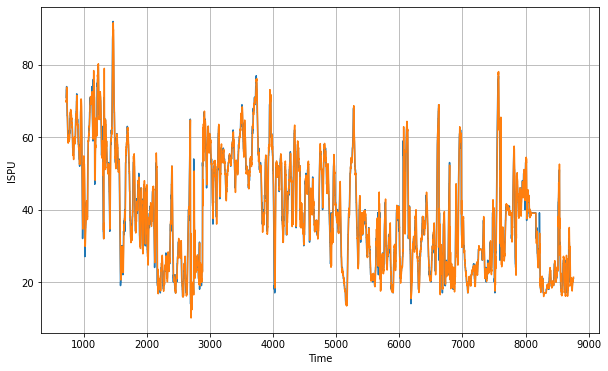

In [15]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

## **Mean Absolute Error**

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1.9760741